# DeepLearning homework
## **Team Deepsea**
## Members:
  - Márton Csáki (Neptun: R0OQD4)
  - Ogleznyev Pável (Neptun: GRKO04)
  - Marák Levente (Neptun: K2DE0K)

# Project
  The Airbus Ship Detection Challenge on Kaggle is a computer vision competition that tasks participants with developing models to automatically identify and localize ships in satellite imagery. The goal is to create an algorithm that can accurately draw bounding boxes or pixel-level masks around ships, thereby aiding maritime surveillance and efficiency. This project involves significant work in image segmentation and object detection using machine learning techniques.
  https://www.kaggle.com/competitions/airbus-ship-detection

## Key Aspects of the Project
  **Goal:** To automatically detect and localize ships in satellite images.

  **Data:** A large dataset of high-resolution satellite images provided by Airbus Defence and Space.

  **Task:** This is primarily an image segmentation challenge, where models must output masks that delineate the exact shape and location of each ship.

  **Application:** The resulting models have practical applications in maritime security, tracking, and logistics.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import cv2
import os
import matplotlib.pyplot as plt

# Mount Google Drive and set the data directory
Our data is too large to simply download from the copetition's site, so we uploaded it using Google Drive.

## 1. Step: Paths and Settings

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
DRIVE_BASE_DIR = "/content/drive/MyDrive/DeepLearn/airbus-ship-detection"
TRAIN_IMG_DIR = os.path.join(DRIVE_BASE_DIR, "train_v2")
CSV_PATH = os.path.join(DRIVE_BASE_DIR, "train_ship_segmentations_v2.csv")

In [4]:
# 768x768 is too large for initial training.
# Start with a smaller but still meaningful size. 224x224 is too small.
IMG_SIZE = (256, 256)
BATCH_SIZE = 16

## 2. Step: Load and Prepare Metadata (from CSV)

In [5]:
print("Loading metadata...")
df = pd.read_csv(CSV_PATH)

# Handle missing values (NaN -> NO_SHIP)
df['EncodedPixels'] = df['EncodedPixels'].fillna('NO_SHIP')

# Group by ImageId (one image can have multiple ships/rows)
metadata = df.groupby('ImageId')['EncodedPixels'].apply(list).reset_index()

# Create 'has_ship' column for filtering
def check_has_ship(rle_list):
    if len(rle_list) == 1 and rle_list[0] == 'NO_SHIP':
        return 0
    return 1

metadata['has_ship'] = metadata['EncodedPixels'].apply(check_has_ship)

# If no ship, replace the RLE list with an empty list
metadata.loc[metadata['has_ship'] == 0, 'EncodedPixels'] = metadata.loc[metadata['has_ship'] == 0, 'ImageId'].apply(lambda x: [])

print(f"Total number of images: {len(metadata)}")

Loading metadata...
Total number of images: 192556


#Split


## 3. Step: Split Data (Train/Validation IDs)
# Split the metadata DataFrame, not the actual files

In [6]:
print("Splitting and balancing data...")

# Initial split (80% Train, 20% Validation)
train_df_raw, val_df = train_test_split(
    metadata,
    test_size=0.2,
    random_state=42,
    stratify=metadata['has_ship']
)

# --- BALANCING THE DATA ---
# Keep all images with ships
train_ships = train_df_raw[train_df_raw['has_ship'] == 1]

# Sample empty images to match the number of ship images (1:1 ratio)
# This forces the model to learn features, not just predict "water" everywhere.
train_empty = train_df_raw[train_df_raw['has_ship'] == 0].sample(len(train_ships), random_state=42)

# Concatenate and shuffle
train_df_balanced = pd.concat([train_ships, train_empty]).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Original training size: {len(train_df_raw)}")
print(f"Balanced training size (used for training): {len(train_df_balanced)}")
print(f"Validation size (remains original): {len(val_df)}")

Splitting and balancing data...
Original training size: 154044
Balanced training size (used for training): 68090
Validation size (remains original): 38512


## 4. Step: Helper Functions (Mask Handling)
# Converts RLE-encoded strings into binary masks

In [7]:
def rle_to_mask(rle_list, shape=(768, 768)):
    """ Converts RLE string list to a binary mask. """
    master_mask = np.zeros(shape[0] * shape[1], dtype=np.uint8)

    for rle_string in rle_list:
        if rle_string == 'NO_SHIP' or rle_string == '':
            continue

        s = rle_string.split()
        starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
        starts -= 1

        for lo, hi in zip(starts, starts + lengths):
            master_mask[lo:hi] = 1

    master_mask = master_mask.reshape(shape).T
    master_mask = np.expand_dims(master_mask, axis=-1)
    return master_mask

## 5. Step: Main Data Pipeline (Generator)

In [8]:
def data_generator(df):
    """ Yields (image, mask) pairs for the model. """
    for _, row in df.iterrows():
        image_id = row['ImageId']
        rle_list = row['EncodedPixels']
        img_path = os.path.join(TRAIN_IMG_DIR, image_id)

        # Load Image
        img = cv2.imread(img_path)
        if img is None: continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, IMG_SIZE)
        img = img / 255.0 # Normalize to [0, 1]

        # Load Mask
        mask = rle_to_mask(rle_list)
        mask = cv2.resize(mask, IMG_SIZE, interpolation=cv2.INTER_NEAREST)
        mask = np.expand_dims(mask, axis=-1) if mask.ndim == 2 else mask

        yield img.astype(np.float32), mask.astype(np.float32)

## 6. Step: Create tf.data.Dataset

In [9]:
print("Building TensorFlow pipelines...")

# Training Pipeline (Uses the BALANCED dataset)
train_ds = tf.data.Dataset.from_generator(
    lambda: data_generator(train_df_balanced),
    output_signature=(
        tf.TensorSpec(shape=(*IMG_SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(*IMG_SIZE, 1), dtype=tf.float32)
    )
).shuffle(500).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Validation Pipeline (Uses the ORIGINAL distribution)
val_ds = tf.data.Dataset.from_generator(
    lambda: data_generator(val_df),
    output_signature=(
        tf.TensorSpec(shape=(*IMG_SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(*IMG_SIZE, 1), dtype=tf.float32)
    )
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("Datasets ready.")

Building TensorFlow pipelines...
Datasets ready.


## 7. Step: Visualization (Verification)

In [ ]:
print("Visualizing a batch...")
images, masks = next(iter(train_ds))

plt.figure(figsize=(15, 6))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    plt.title("Input Image")
    plt.axis('off')

    plt.subplot(2, 5, i + 6)
    plt.imshow(masks[i], cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

plt.tight_layout()
plt.show()

Visualizing a batch...


8. Step: Define U-Net Architecture
Itt építjük fel a hálót.

In [39]:

def weighted_binary_crossentropy(pos_weight=50.0):

    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        bce = -(pos_weight * y_true * K.log(y_pred) + (1 - y_true) * K.log(1 - y_pred))
        return K.mean(bce)
    return loss


def dice_coef(y_true, y_pred, smooth=1):
    """Dice koefficients"""
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_loss(y_true, y_pred):
    """Dice loss"""
    return 1 - dice_coef(y_true, y_pred)


def combined_loss(y_true, y_pred):

    wbce = weighted_binary_crossentropy(pos_weight=50.0)(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return wbce + dice


def iou_metric(y_true, y_pred, threshold=0.5):
    """IoU metric"""
    y_pred_binary = K.cast(K.greater(y_pred, threshold), K.floatx())
    intersection = K.sum(y_true * y_pred_binary)
    union = K.sum(y_true) + K.sum(y_pred_binary) - intersection
    return (intersection + 1e-7) / (union + 1e-7)


def precision_metric(y_true, y_pred, threshold=0.5):
    """Precision metric"""
    y_pred_binary = K.cast(K.greater(y_pred, threshold), K.floatx())
    true_positives = K.sum(y_true * y_pred_binary)
    predicted_positives = K.sum(y_pred_binary)
    return (true_positives + 1e-7) / (predicted_positives + 1e-7)


def recall_metric(y_true, y_pred, threshold=0.5):
    """Recall metric"""
    y_pred_binary = K.cast(K.greater(y_pred, threshold), K.floatx())
    true_positives = K.sum(y_true * y_pred_binary)
    actual_positives = K.sum(y_true)
    return (true_positives + 1e-7) / (actual_positives + 1e-7)


def f2_score(y_true, y_pred, threshold=0.5, beta=2):

    y_pred_binary = K.cast(K.greater(y_pred, threshold), K.floatx())

    true_positives = K.sum(y_true * y_pred_binary)
    predicted_positives = K.sum(y_pred_binary)
    actual_positives = K.sum(y_true)

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (actual_positives + K.epsilon())

    f2 = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall + K.epsilon())

    return f2



def build_unet_improved(input_shape):

    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.BatchNormalization()(c1)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    c1 = layers.BatchNormalization()(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    p1 = layers.Dropout(0.1)(p1)

    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.BatchNormalization()(c2)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    c2 = layers.BatchNormalization()(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    p2 = layers.Dropout(0.1)(p2)

    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.BatchNormalization()(c3)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    c3 = layers.BatchNormalization()(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    p3 = layers.Dropout(0.2)(p3)

    # Bottleneck
    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c4)
    c4 = layers.BatchNormalization()(c4)
    c4 = layers.Dropout(0.3)(c4)

    # Decoder
    u5 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = layers.concatenate([u5, c3])
    c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u5)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c5)
    c5 = layers.BatchNormalization()(c5)
    c5 = layers.Dropout(0.2)(c5)

    u6 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c6)
    c6 = layers.BatchNormalization()(c6)
    c6 = layers.Dropout(0.1)(c6)

    u7 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.BatchNormalization()(c7)
    c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c7)
    c7 = layers.BatchNormalization()(c7)

    # Output
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model



print("Building improved U-Net model...")
model = build_unet_improved((256, 256, 3))
model.summary()

Building improved U-Net model...


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 256, 256,  │        896 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_60[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 256, 256,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_61[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 128, 128,  │          0 │ max_pooling2d_12… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 128, 128,  │     18,496 │ dropout_12[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_62[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_63 (Conv2D)  │ (None, 128, 128,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_63[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 64, 64,    │          0 │ max_pooling2d_13… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_64 (Conv2D)  │ (None, 64, 64,    │     73,856 │ dropout_13[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_64[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_65 (Conv2D)  │ (None, 64, 64,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_65[0][0] 

 Total params: 1,931,233 (7.37 MB)

 Trainable params: 1,928,417 (7.36 MB)

 Non-trainable params: 2,816 (11.00 KB)

9. Step: Compile and Train (Tanítás)
Itt adjuk meg a metrikákat. A szegmentálásban az Accuracy (pontosság) csalóka, mert a tenger 99%-a üres, így ha a modell mindig "nincs hajót" mond, akkor is 99%-os lesz. Ezért kell az IoU (Intersection over Union) metrika.

In [45]:


print("Compiling model with improved metrics...")
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=combined_loss,
    metrics=[
        'accuracy',
        iou_metric,
        dice_coef,
        precision_metric,
        recall_metric,
        f2_score
    ]
)

# Callbacks
callbacks_list = [
    ModelCheckpoint(
        "best_ship_model_v2.keras",
        monitor='val_iou_metric',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_iou_metric',
        patience=15,
        restore_best_weights=True,
        mode='max',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_iou_metric',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        mode='max',
        verbose=1
    )
]

# Training
TRAIN_STEPS = len(train_df_balanced) // BATCH_SIZE
VAL_STEPS = 200

print(f"Starting training with {TRAIN_STEPS} steps per epoch...")
print(f"Validation steps: {VAL_STEPS}")

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    steps_per_epoch=25,
    validation_steps=25,
    callbacks=callbacks_list,
    verbose=1
)

print("\n✅ Training completed!")
print(f"Best val_iou_metric: {max(history.history['val_iou_metric']):.4f}")

Compiling model with improved metrics...
Starting training with 4255 steps per epoch...
Validation steps: 200
Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.6021 - dice_coef: 0.0082 - f2_score: 0.0259 - iou_metric: 0.0054 - loss: 1.7162 - precision_metric: 0.0054 - recall_metric: 0.8937
Epoch 1: val_iou_metric improved from -inf to 0.00416, saving model to best_ship_model_v2.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 47s 624ms/step - accuracy: 0.6029 - dice_coef: 0.0083 - f2_score: 0.0261 - iou_metric: 0.0054 - loss: 1.7161 - precision_metric: 0.0054 - recall_metric: 0.8935 - val_accuracy: 0.9931 - val_dice_coef: 0.0030 - val_f2_score: 0.0114 - val_iou_metric: 0.0042 - val_loss: 1.6940 - val_precision_metric: 0.0061 - val_recall_metric: 0.0183 - learning_rate: 1.0000e-04
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.6783 - dice_coef: 0.0089 - f2_score: 0.0344 - iou_metric: 0.0072 - loss: 1.7017 - precision_metric: 0.0072 - recall_metric: 0.9033
Epoch 2: val

10. Step: Evaluation & Visualization (Kiértékelés)
Ez teljesíti a kiértékelési követelményt.

/tmp/ipython-input-2980538598.py:51: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


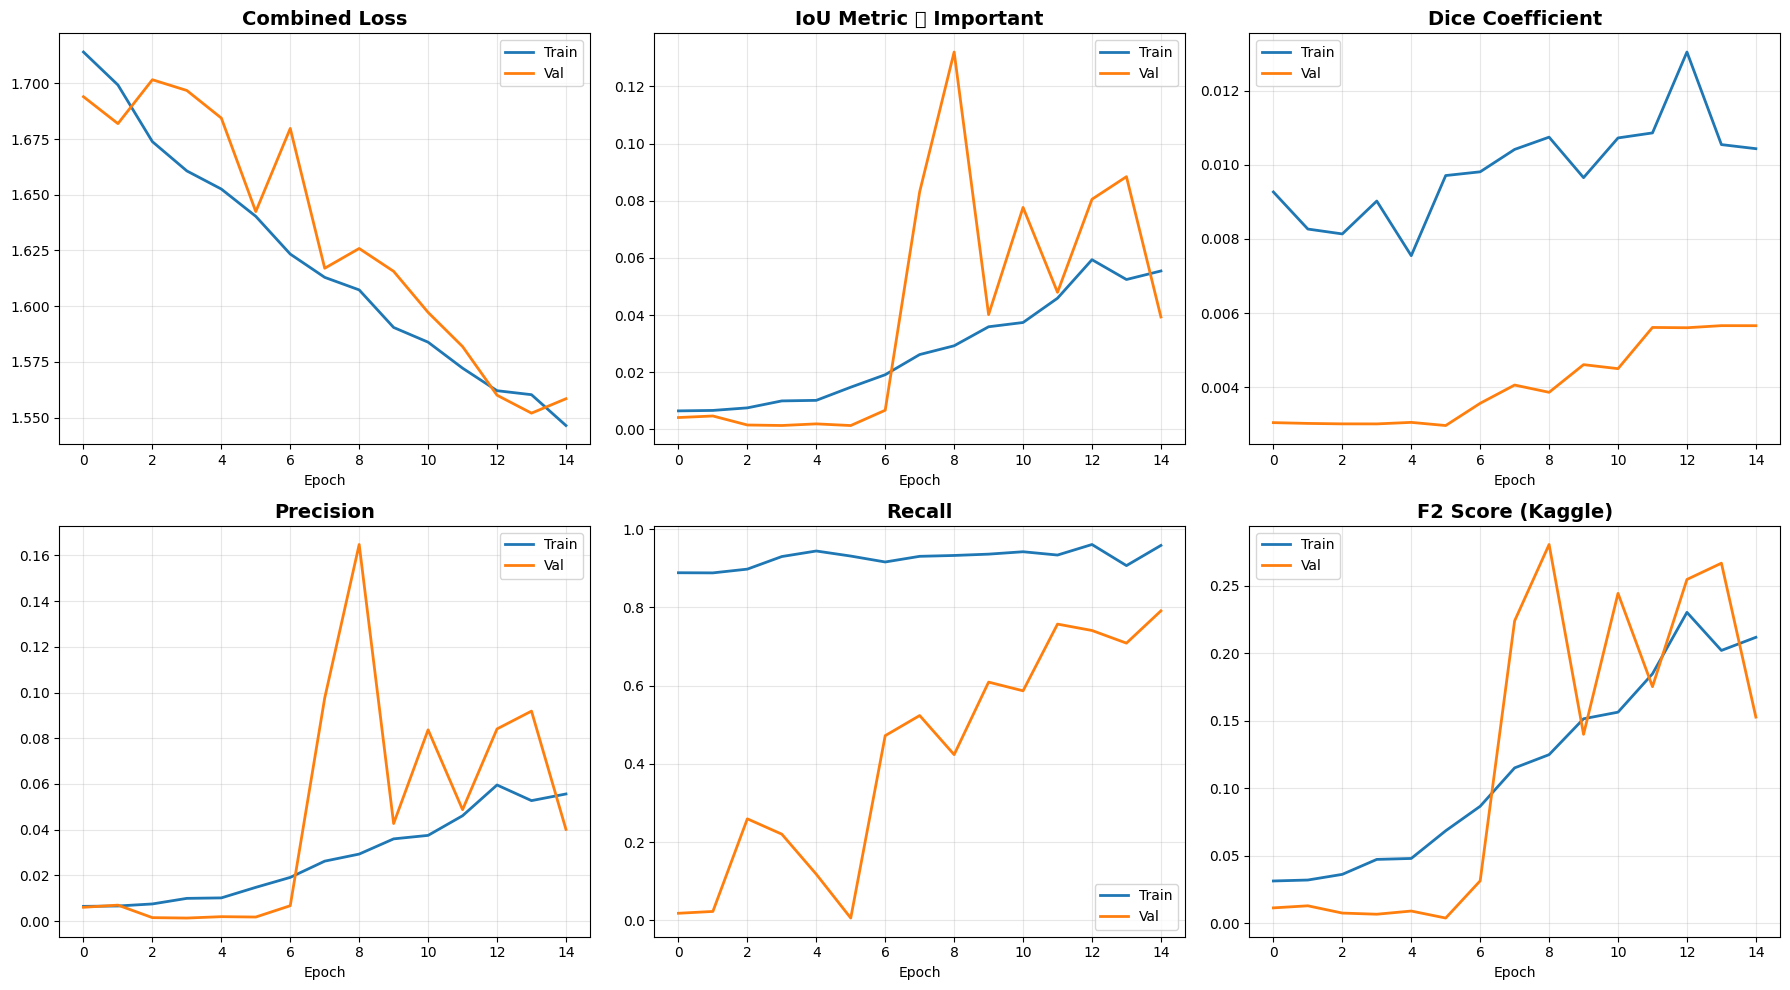


FINAL METRICS
Val IoU:       0.0393
Val Dice:      0.0057
Val Precision: 0.0401
Val Recall:    0.7914
Val F2 Score:  0.1526


In [46]:


fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Loss
axes[0, 0].plot(history.history['loss'], label='Train', linewidth=2)
axes[0, 0].plot(history.history['val_loss'], label='Val', linewidth=2)
axes[0, 0].set_title('Combined Loss', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# IoU
axes[0, 1].plot(history.history['iou_metric'], label='Train', linewidth=2)
axes[0, 1].plot(history.history['val_iou_metric'], label='Val', linewidth=2)
axes[0, 1].set_title('IoU Metric ⭐ Important', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Dice
axes[0, 2].plot(history.history['dice_coef'], label='Train', linewidth=2)
axes[0, 2].plot(history.history['val_dice_coef'], label='Val', linewidth=2)
axes[0, 2].set_title('Dice Coefficient', fontsize=14, fontweight='bold')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Precision
axes[1, 0].plot(history.history['precision_metric'], label='Train', linewidth=2)
axes[1, 0].plot(history.history['val_precision_metric'], label='Val', linewidth=2)
axes[1, 0].set_title('Precision', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Recall
axes[1, 1].plot(history.history['recall_metric'], label='Train', linewidth=2)
axes[1, 1].plot(history.history['val_recall_metric'], label='Val', linewidth=2)
axes[1, 1].set_title('Recall', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# F2 Score (Kaggle metric)
axes[1, 2].plot(history.history['f2_score'], label='Train', linewidth=2)
axes[1, 2].plot(history.history['val_f2_score'], label='Val', linewidth=2)
axes[1, 2].set_title('F2 Score (Kaggle)', fontsize=14, fontweight='bold')
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics
print("\n" + "="*60)
print("FINAL METRICS")
print("="*60)
print(f"Val IoU:       {history.history['val_iou_metric'][-1]:.4f}")
print(f"Val Dice:      {history.history['val_dice_coef'][-1]:.4f}")
print(f"Val Precision: {history.history['val_precision_metric'][-1]:.4f}")
print(f"Val Recall:    {history.history['val_recall_metric'][-1]:.4f}")
print(f"Val F2 Score:  {history.history['val_f2_score'][-1]:.4f}")
print("="*60)

In [47]:


def smart_postprocess(pred_mask, confidence_threshold=0.6, min_size=50, max_size=8000):


    # 1. Confidence check
    if pred_mask.max() < confidence_threshold:
        return np.zeros_like(pred_mask, dtype=np.uint8)

    # 2. Threshold
    binary = (pred_mask > 0.5).astype(np.uint8)


    kernel = np.ones((3, 3), np.uint8)
    # Opening
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)
    # Closing
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)


    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
        binary, connectivity=8
    )

    output = np.zeros_like(binary)
    for i in range(1, num_labels):  # 0 = background
        area = stats[i, cv2.CC_STAT_AREA]
        if min_size < area < max_size:
            output[labels == i] = 1

    return output


def predict_with_tta(model, image):
    """
    Test Time Augmentation:
    """
    predictions = []

    # Original
    pred = model.predict(np.expand_dims(image, 0), verbose=0)[0, :, :, 0]
    predictions.append(pred)

    # Horizontal flip
    img_flipped = np.fliplr(image)
    pred_flipped = model.predict(np.expand_dims(img_flipped, 0), verbose=0)[0, :, :, 0]
    predictions.append(np.fliplr(pred_flipped))

    # Vertical flip
    img_vflipped = np.flipud(image)
    pred_vflipped = model.predict(np.expand_dims(img_vflipped, 0), verbose=0)[0, :, :, 0]
    predictions.append(np.flipud(pred_vflipped))

    # Average all predictions
    avg_pred = np.mean(predictions, axis=0)

    return avg_pred


print("✅ Post-processing functions ready!")

✅ Post-processing functions ready!



Generating predictions with post-processing...
Running model predictions...

Prediction Statistics:
  Min:  0.3126
  Max:  0.9889
  Mean: 0.4455


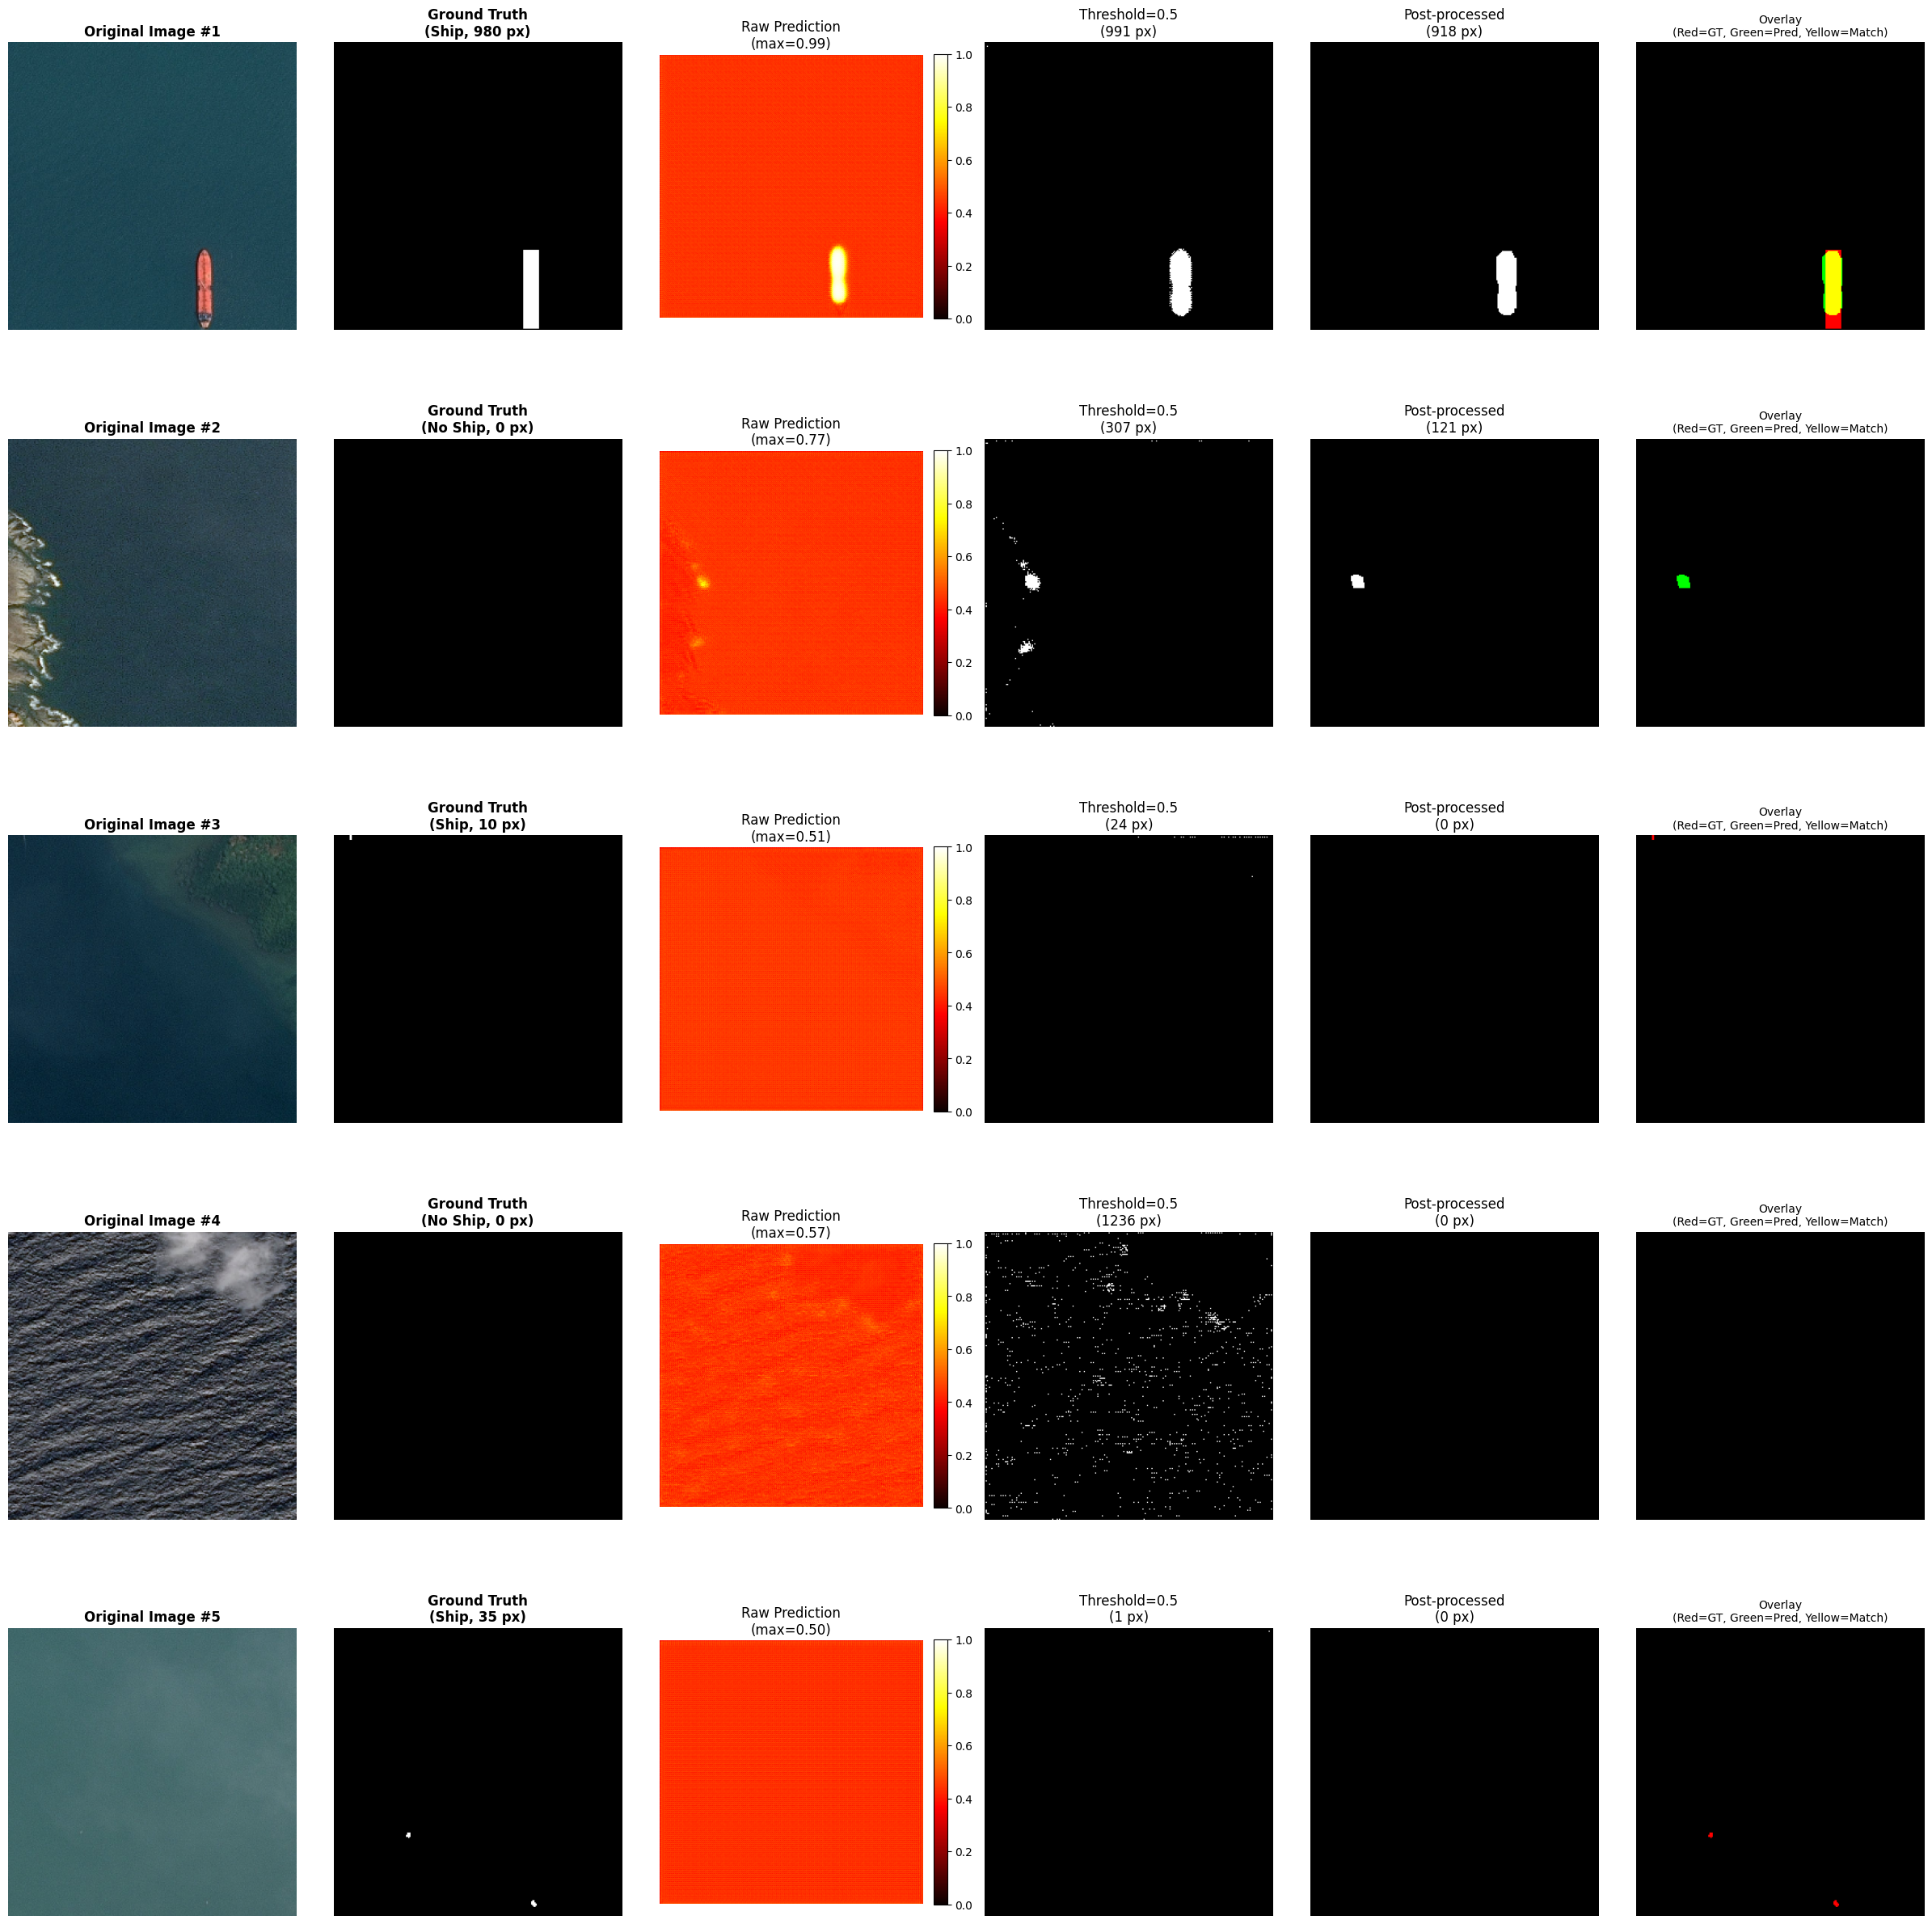


BATCH METRICS (with post-processing)
Precision: 0.5935
Recall:    0.3883
F2 Score:  0.4171


In [48]:


print("\nGenerating predictions with post-processing...")
val_images, val_masks = next(iter(val_ds))


val_images_np = val_images.numpy()
val_masks_np = val_masks.numpy()

# Predictions
print("Running model predictions...")
predictions = model.predict(val_images, verbose=0)

# Statistics
print(f"\nPrediction Statistics:")
print(f"  Min:  {predictions.min():.4f}")
print(f"  Max:  {predictions.max():.4f}")
print(f"  Mean: {predictions.mean():.4f}")

# Visualization
plt.figure(figsize=(24, 25))

for i in range(5):
    # Original Image
    plt.subplot(5, 6, i*6 + 1)
    plt.imshow(val_images_np[i])
    plt.title(f"Original Image #{i+1}", fontsize=12, fontweight='bold')
    plt.axis('off')

    # Ground Truth Mask
    plt.subplot(5, 6, i*6 + 2)
    gt_mask = val_masks_np[i, :, :, 0]
    plt.imshow(gt_mask, cmap='gray')
    has_ship = gt_mask.sum() > 0
    ship_pixels = int(gt_mask.sum())
    plt.title(f"Ground Truth\n({'Ship' if has_ship else 'No Ship'}, {ship_pixels} px)",
              fontsize=12, fontweight='bold')
    plt.axis('off')

    # Raw Prediction (heatmap)
    plt.subplot(5, 6, i*6 + 3)
    raw_pred = predictions[i, :, :, 0]
    plt.imshow(raw_pred, cmap='hot', vmin=0, vmax=1)
    plt.title(f"Raw Prediction\n(max={raw_pred.max():.2f})", fontsize=12)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.axis('off')

    # Threshold 0.5
    plt.subplot(5, 6, i*6 + 4)
    thresh_mask = (raw_pred > 0.5).astype(np.uint8)
    plt.imshow(thresh_mask, cmap='gray')
    thresh_pixels = int(thresh_mask.sum())
    plt.title(f"Threshold=0.5\n({thresh_pixels} px)", fontsize=12)
    plt.axis('off')

    # Smart Post-processing
    plt.subplot(5, 6, i*6 + 5)
    cleaned = smart_postprocess(raw_pred, confidence_threshold=0.6, min_size=50, max_size=8000)
    plt.imshow(cleaned, cmap='gray')
    cleaned_pixels = int(cleaned.sum())
    plt.title(f"Post-processed\n({cleaned_pixels} px)", fontsize=12)
    plt.axis('off')

    # Overlay (GT vs Prediction)
    plt.subplot(5, 6, i*6 + 6)
    overlay = np.zeros((*gt_mask.shape, 3))
    overlay[:, :, 0] = gt_mask  # Ground truth = Red
    overlay[:, :, 1] = cleaned   # Prediction = Green
    # Yellow where they overlap
    plt.imshow(overlay)
    plt.title(f"Overlay\n(Red=GT, Green=Pred, Yellow=Match)", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Calculate metrics on this batch
print("\n" + "="*60)
print("BATCH METRICS (with post-processing)")
print("="*60)

total_tp = 0  # True Positives
total_fp = 0  # False Positives
total_fn = 0  # False Negatives

for i in range(len(val_images_np)):
    gt = val_masks_np[i, :, :, 0]
    pred = smart_postprocess(predictions[i, :, :, 0])

    tp = np.sum((gt == 1) & (pred == 1))
    fp = np.sum((gt == 0) & (pred == 1))
    fn = np.sum((gt == 1) & (pred == 0))

    total_tp += tp
    total_fp += fp
    total_fn += fn

precision = total_tp / (total_tp + total_fp + 1e-7)
recall = total_tp / (total_tp + total_fn + 1e-7)
f2 = (1 + 4) * (precision * recall) / (4 * precision + recall + 1e-7)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F2 Score:  {f2:.4f}")
print("="*60)